In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv('/content/train_v9rqX0R.csv')
df_test = pd.read_csv('/content/test_AbJTz2l.csv')

df_train2 = df_train.copy()
df_test2 = df_test.copy()

df_train2.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
checking_missing_values = pd.DataFrame({'Train': df_train.isnull().mean() * 100, 'Test': df_test.isnull().mean() * 100}).round(2).sort_values(by='Train', ascending=False)
checking_missing_values

,Train,Test
Outlet_Size,28.28,28.27
Item_Weight,17.17,17.18
Item_Fat_Content,0.00,0.00
Item_Identifier,0.00,0.00
Item_MRP,0.00,0.00
Item_Outlet_Sales,0.00,NaN
Item_Type,0.00,0.00
Item_Visibility,0.00,0.00
Outlet_Establishment_Year,0.00,0.00
Outlet_Identifier,0.00,0.00


# 2. Feature Engineering - Part 1 - Imputation

In [4]:
from datetime import datetime

# Assume a column 'Outlet_Establishment_Year'
df_train2['Years_Operating'] = datetime.now().year - df_train2['Outlet_Establishment_Year']
df_test2['Years_Operating'] = datetime.now().year - df_test2['Outlet_Establishment_Year']


# Labeling Item Identifer
df_train2['Item_Category'] = df_train2['Item_Identifier'].str[:2]
df_train2['Item_Category'].replace({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'}, inplace=True)

df_test2['Item_Category'] = df_test2['Item_Identifier'].str[:2]
df_test2['Item_Category'].replace({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'}, inplace=True)

# Maping Duplicate Item_Fat_Content
df_train2['Item_Fat_Content'].replace({'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'}, inplace=True)
df_test2['Item_Fat_Content'].replace({'LF':'Low Fat', 'low fat':'Low Fat', 'reg':'Regular'}, inplace=True)

# Imputation in Item Weight
df_train2['Item_Weight'] = df_train2['Item_Weight'].interpolate(method='nearest', axis=0)
df_test2['Item_Weight'] = df_test2['Item_Weight'].interpolate(method='nearest', axis=0)

# Imputing Binary Data in Outlet_Size for missing values
df_train2['Outlet_Size'] = df_train2['Outlet_Size'].fillna(df_train2.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.mode().iloc[0]))
df_test2['Outlet_Size'] = df_test2['Outlet_Size'].fillna(df_test2.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.mode().iloc[0]))


# Visibility Imputations & Transformation for Skews
from sklearn.preprocessing import PowerTransformer

# # Replace 0 values with NaN
df_train2['Item_Visibility'] = df_train2['Item_Visibility'].replace(0, np.nan)
df_test2['Item_Visibility'] = df_test2['Item_Visibility'].replace(0, np.nan)


df_train2['Item_Visibility'] = df_train2['Item_Visibility'].interpolate(method='linear', axis=0)
df_test2['Item_Visibility'] = df_test2['Item_Visibility'].interpolate(method='linear', axis=0)

pt_yeo = PowerTransformer(method='yeo-johnson')
df_train2['Item_Visibility_Transformed'] = pt_yeo.fit_transform(df_train2['Item_Visibility'].values.reshape(-1, 1)).ravel()
df_test2['Item_Visibility_Transformed'] = pt_yeo.fit_transform(df_test2['Item_Visibility'].values.reshape(-1, 1)).ravel()

# Update MRP values where Item_MRP > Item_Outlet_Sales to match Item_Outlet_Sales
df_train2.loc[df_train2['Item_MRP'] > df_train2['Item_Outlet_Sales'], 'Item_MRP'] = df_train2['Item_Outlet_Sales']

<ipython-input-4-48850b13f124>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train2['Item_Category'].replace({'FD':'Food', 'NC':'Non-Consumable', 'DR':'Drinks'}, inplace=True)
<ipython-input-4-48850b13f124>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

# Feature Engineering Part 2 - Combination

In [5]:
# Combining Feature

df_train2['MRP_Visibility'] = df_train2['Item_MRP'] * df_train2['Item_Visibility']
df_test2['MRP_Visibility'] = df_test2['Item_MRP'] * df_test2['Item_Visibility']

# Price Per Unit
df_train2['Price_Per_Unit'] = df_train2['Item_MRP'] / df_train2['Item_Weight']
df_test2['Price_Per_Unit'] = df_test2['Item_MRP'] / df_test2['Item_Weight']

# Item Content Type - Classfication
df_train2['Fact_Conetent_Type'] = df_train2['Item_Fat_Content']+" "+df_train2['Item_Category']
df_test2['Fact_Conetent_Type'] = df_test2['Item_Fat_Content']+" "+df_test2['Item_Category']

# Visibility_Per_Price
df_train2['Visibility_Per_Price'] = df_train2['Item_Visibility'] / df_train2['Item_MRP']
df_test2['Visibility_Per_Price'] = df_test2['Item_Visibility'] / df_test2['Item_MRP']

# Weight_Fat_Combination
df_train2['Weight_Fat_Combination'] = df_train2['Item_Weight'] * df_train2['Item_Fat_Content'].map({'Low Fat': 0, 'Regular': 1})
df_test2['Weight_Fat_Combination'] = df_test2['Item_Weight'] * df_test2['Item_Fat_Content'].map({'Low Fat': 0, 'Regular': 1})

# Location_Type_Combination - Classfication
df_train2['Location_Type_Combination'] = df_train2['Outlet_Location_Type'] + '_' + df_train2['Outlet_Type']
df_test2['Location_Type_Combination'] = df_test2['Outlet_Location_Type'] + '_' + df_test2['Outlet_Type']

# EDA
## # Understading The training data post imputation & combination

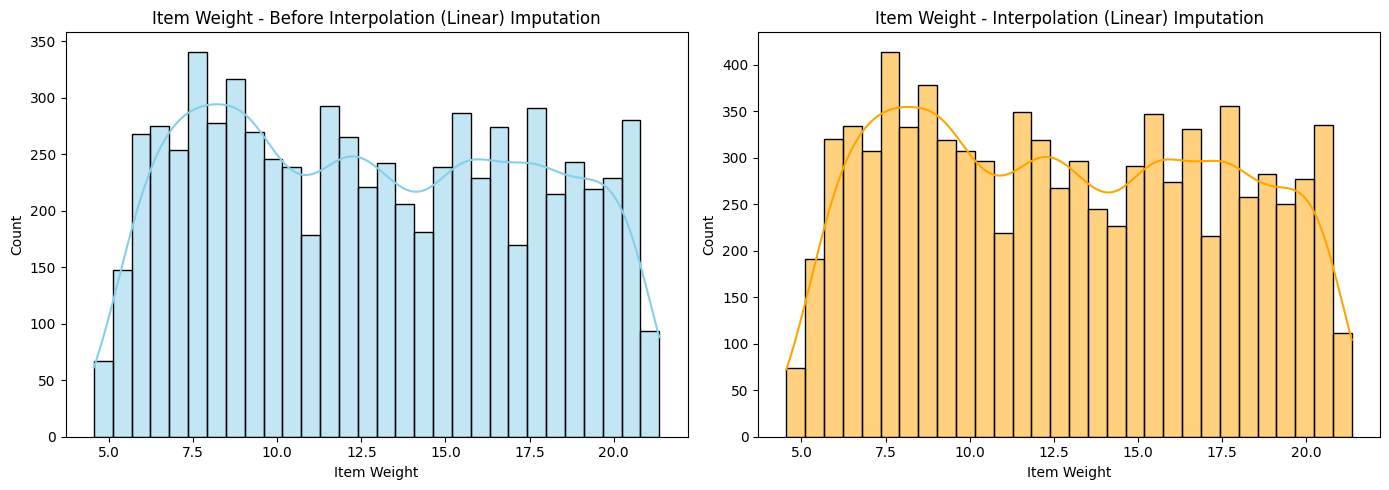

In [6]:
# Weight Distribution Chart Before & After

# Plotting
plt.figure(figsize=(14, 5))

# Histogram - Before
plt.subplot(1, 2, 1)
sns.histplot(df_train['Item_Weight'], bins=30, kde=True, color='skyblue')
plt.title('Item Weight - Before Interpolation (Linear) Imputation')
plt.xlabel('Item Weight')
plt.ylabel('Count')

# Histogram - After
plt.subplot(1, 2, 2)
sns.histplot(df_train2['Item_Weight'], bins=30, kde=True, color='orange')
plt.title('Item Weight - Interpolation (Linear) Imputation')
plt.xlabel('Item Weight')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


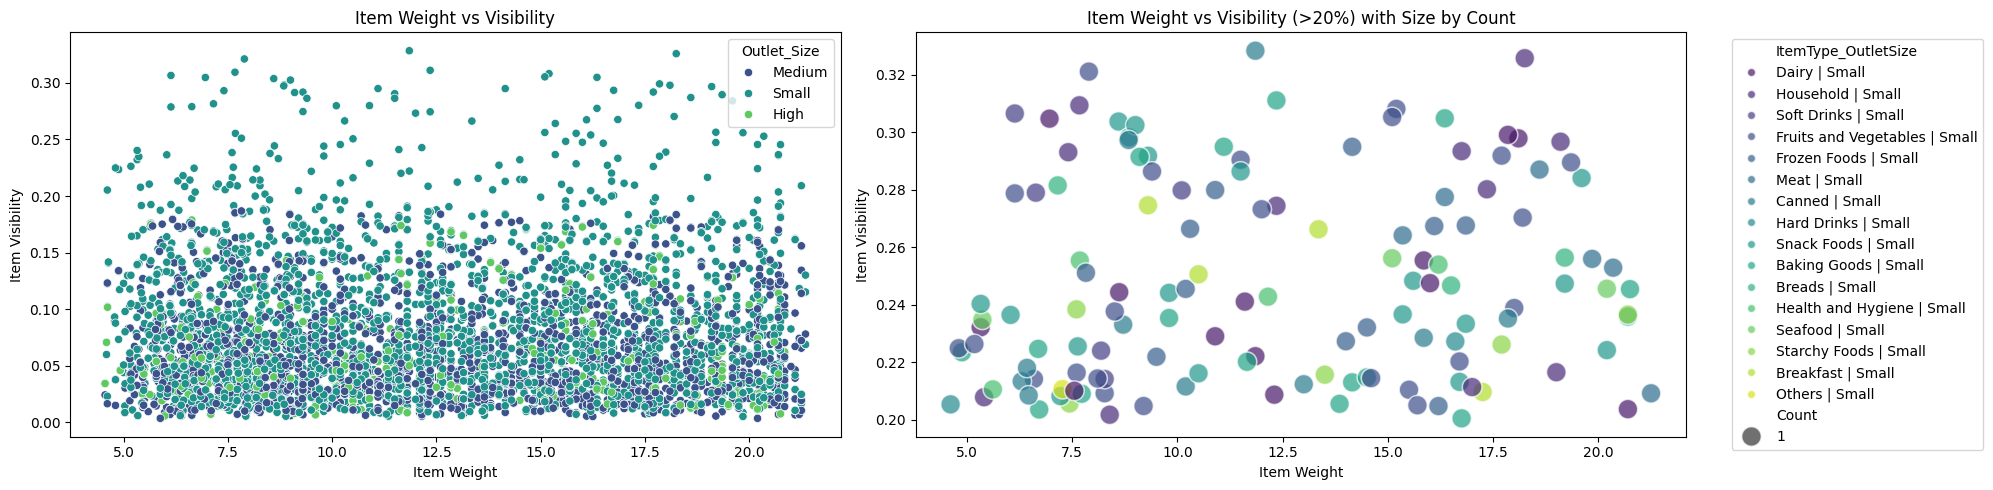

In [7]:
# Item Visibility Overall & Distribution in > 20% Density
# Plotting
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df_train2, x='Item_Weight', y='Item_Visibility', hue='Outlet_Size', palette='viridis')
plt.title('Item Weight vs Visibility')
plt.xlabel('Item Weight')
plt.ylabel('Item Visibility')



# Filter visibility > 20%
filtered_df = df_train2[df_train2['Item_Visibility'] > 0.2].copy()

# Create combined hue
filtered_df['ItemType_OutletSize'] = filtered_df['Item_Type'] + ' | ' + filtered_df['Outlet_Size']

# Count duplicate points
count_df = (filtered_df.groupby(['Item_Weight', 'Item_Visibility']).size().reset_index(name='Count'))

# Merge count into filtered_df
filtered_df = pd.merge(filtered_df, count_df, on=['Item_Weight', 'Item_Visibility'], how='left')


plt.subplot(1, 2, 2)
# Scatterplot with size by count
sns.scatterplot(
    data=filtered_df,
    x='Item_Weight',
    y='Item_Visibility',
    hue='ItemType_OutletSize',
    size='Count',
    sizes=(200, 2000),  # control min/max size
    alpha=0.7,
    legend='full',
    palette='viridis'
)

plt.title('Item Weight vs Visibility (>20%) with Size by Count')
plt.xlabel('Item Weight')
plt.ylabel('Item Visibility')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

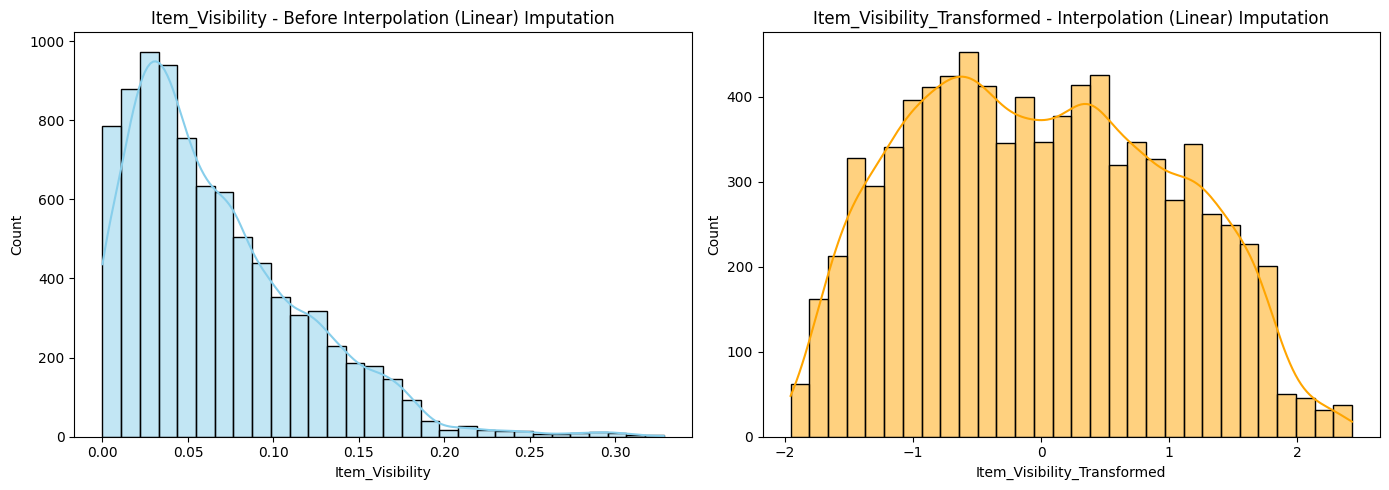

In [8]:
# Visibility Distribution Chart Before & After

# Plotting
plt.figure(figsize=(14, 5))

# Histogram - Before
plt.subplot(1, 2, 1)
sns.histplot(df_train['Item_Visibility'], bins=30, kde=True, color='skyblue')
plt.title('Item_Visibility - Before Interpolation (Linear) Imputation')
plt.xlabel('Item_Visibility')
plt.ylabel('Count')

# Histogram - After
plt.subplot(1, 2, 2)
sns.histplot(df_train2['Item_Visibility_Transformed'], bins=30, kde=True, color='orange')
plt.title('Item_Visibility_Transformed - Interpolation (Linear) Imputation')
plt.xlabel('Item_Visibility_Transformed')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

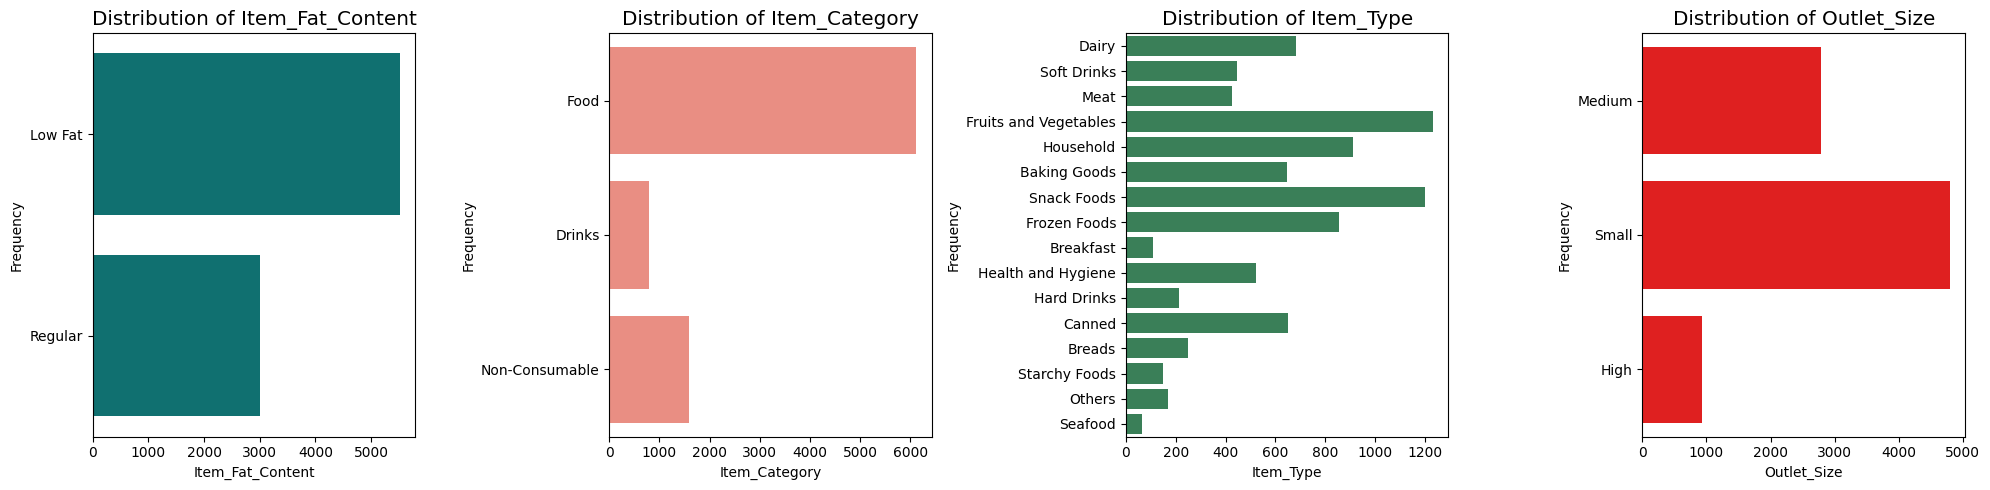

In [9]:
# Distibution of data in Categorical items
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plt.style.use('ggplot')

columns_bin = ['Item_Fat_Content', 'Item_Category','Item_Type', 'Outlet_Size']
colors_bin = ['teal', 'salmon', 'seagreen','red']

# Plot each distribution
for i, col in enumerate(columns_bin):
    sns.countplot(y=df_train2[col], ax=axs[i], color=colors_bin[i])
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', labelrotation=0)  # 👈 horizontal labels

plt.tight_layout()
plt.show()


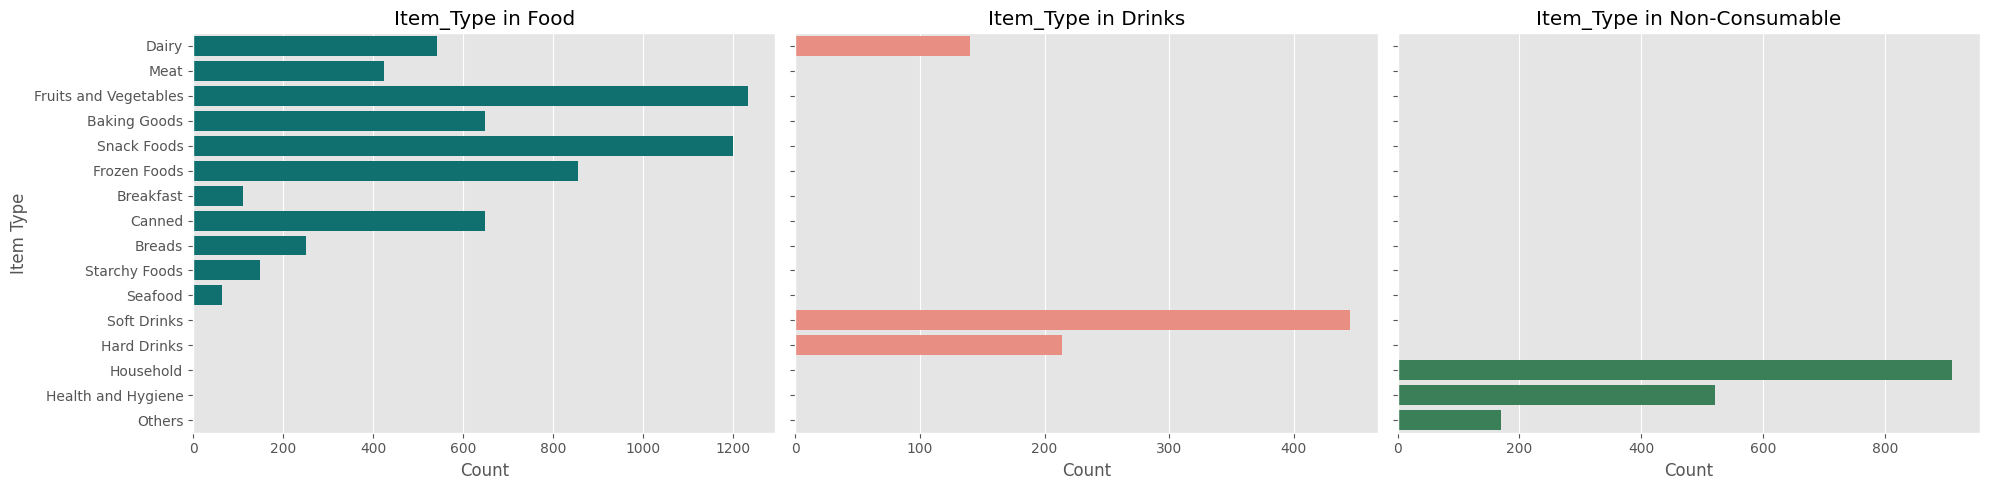

In [10]:
# Chart Showing Item_Category & Sub-Category Distribution
top_categories = df_train2['Item_Category'].unique()[:3]
colors_cate = ['teal', 'salmon', 'seagreen']

# Setup subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
plt.style.use('ggplot')

# Plot each category
for i, cat in enumerate(top_categories):
    sns.countplot(data=df_train2[df_train2['Item_Category'] == cat], y='Item_Type', ax=axs[i], color=colors_cate[i] )
    axs[i].set_title(f'Item_Type in {cat}')
    axs[i].set_xlabel('Count')
    axs[i].set_ylabel('Item Type')

plt.tight_layout()
plt.show()

## Chart Showing Skewness in the data

<ipython-input-11-9de61ae88da3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_train2, x='Outlet_Identifier', y='Item_Outlet_Sales', palette='viridis')


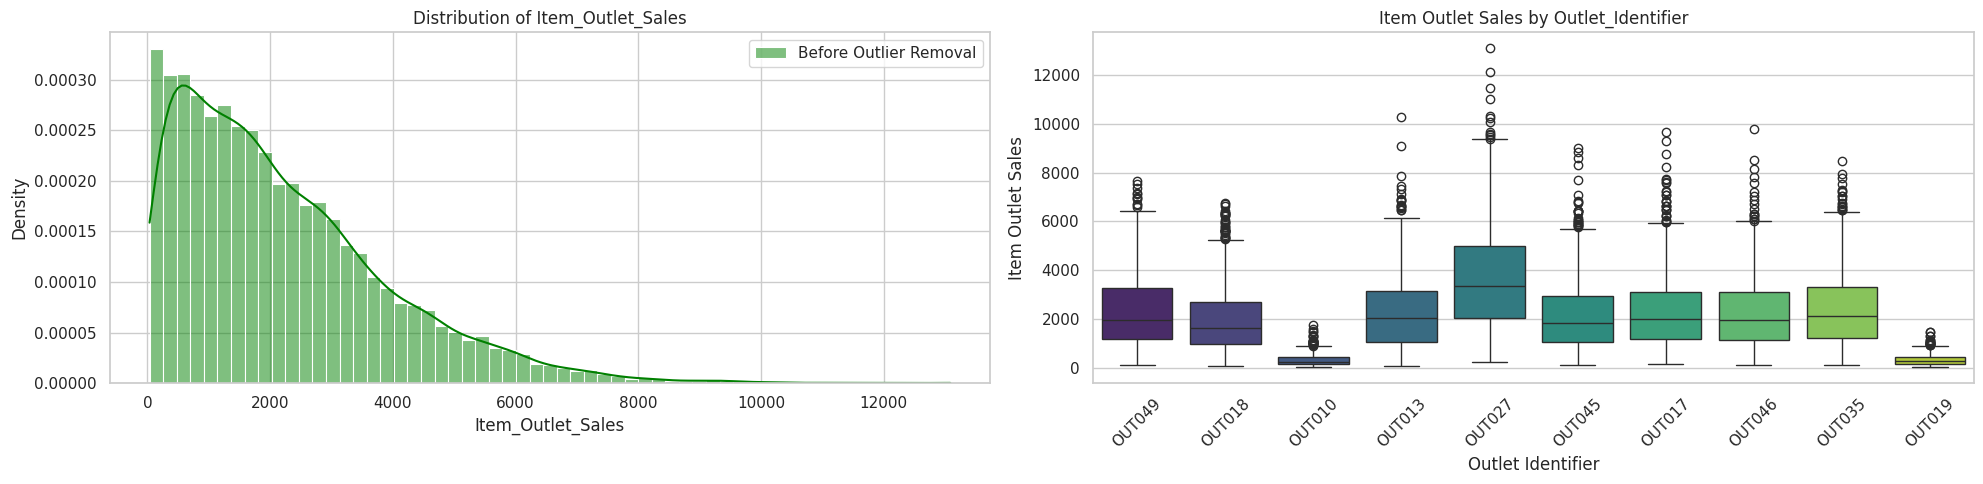

In [11]:

plt.figure(figsize=(20, 5))
sns.set(style="whitegrid")

# Subplot 1: Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_train2['Item_Outlet_Sales'], label='Before Outlier Removal', color='green', kde=True, stat="density", alpha=0.5)
plt.title('Distribution of Item_Outlet_Sales')
plt.xlabel('Item_Outlet_Sales')
plt.ylabel('Density')
plt.legend()

# Subplot 2: Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df_train2, x='Outlet_Identifier', y='Item_Outlet_Sales', palette='viridis')
plt.title('Item Outlet Sales by Outlet_Identifier')
plt.xlabel('Outlet Identifier')
plt.ylabel('Item Outlet Sales')
plt.xticks(rotation=45)

# Final layout and display
plt.tight_layout()
plt.show()


In [12]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Item_Identifier              8523 non-null   object 
 1   Item_Weight                  8523 non-null   float64
 2   Item_Fat_Content             8523 non-null   object 
 3   Item_Visibility              8523 non-null   float64
 4   Item_Type                    8523 non-null   object 
 5   Item_MRP                     8523 non-null   float64
 6   Outlet_Identifier            8523 non-null   object 
 7   Outlet_Establishment_Year    8523 non-null   int64  
 8   Outlet_Size                  8523 non-null   object 
 9   Outlet_Location_Type         8523 non-null   object 
 10  Outlet_Type                  8523 non-null   object 
 11  Item_Outlet_Sales            8523 non-null   float64
 12  Years_Operating              8523 non-null   int64  
 13  Item_Category     

# Model Building
## Encoding Data for Object DataType

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Encode the 'City' column
df_train2['Item_Identifier'] = le.fit_transform(df_train2['Item_Identifier'])
df_train2['Item_Fat_Content'] = le.fit_transform(df_train2['Item_Fat_Content'])
df_train2['Item_Type'] = le.fit_transform(df_train2['Item_Type'])
df_train2['Outlet_Identifier'] = le.fit_transform(df_train2['Outlet_Identifier'])
df_train2['Outlet_Size'] = le.fit_transform(df_train2['Outlet_Size'])
df_train2['Outlet_Location_Type'] = le.fit_transform(df_train2['Outlet_Location_Type'])
df_train2['Outlet_Type'] = le.fit_transform(df_train2['Outlet_Type'])
df_train2['Item_Category'] = le.fit_transform(df_train2['Item_Category'])
# df_train2['Fact_Conetent_Type'] = le.fit_transform(df_train2['Fact_Conetent_Type'])
# df_train2['Location_Type_Combination'] = le.fit_transform(df_train2['Location_Type_Combination'])

## Split the Data for Train & Test

In [14]:
X = df_train2.drop(['Item_Outlet_Sales','Weight_Fat_Combination','Location_Type_Combination','Fact_Conetent_Type'], axis=1)
y = df_train2['Item_Outlet_Sales']

## Model Building using more efficient method

In [15]:
# # Required Libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score ,mean_squared_error ,root_mean_squared_error ,mean_absolute_error

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (for linear models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = []

# Helper to Evaluate Models
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    results.append({
        "Model": name,
        "MAE": round(mae, 4),
        "MSE": round(mse, 4),
        "RMSE": round(rmse,4),
        "R² Score": round(r2, 4)
    })

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
evaluate_model("Linear Regression", y_test, y_pred_lr)

# 2. Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)
evaluate_model("Lasso Regression", y_test, y_pred_lasso)

# 3. Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)
evaluate_model("Ridge Regression", y_test, y_pred_ridge)

# 4. ElasticNet Regression
elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic.fit(X_train_scaled, y_train)
y_pred_elastic = elastic.predict(X_test_scaled)
evaluate_model("ElasticNet Regression", y_test, y_pred_elastic)

# 5. Random Forest Regressor (no scaling needed)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
evaluate_model("Random Forest", y_test, y_pred_rf)

# 6. XGBoost Regressor (no scaling needed)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
evaluate_model("XGBoost", y_test, y_pred_xgb)

# Convert to DataFrame for tabular view
results_df = pd.DataFrame(results).sort_values(by="R² Score", ascending=False)
print(results_df)


                   Model       MAE           MSE       RMSE  R² Score
5                XGBoost  741.2196  1.113568e+06  1055.2573    0.5903
4          Random Forest  760.4402  1.189333e+06  1090.5656    0.5624
0      Linear Regression  849.8052  1.286985e+06  1134.4536    0.5265
1       Lasso Regression  849.7394  1.286948e+06  1134.4374    0.5265
2       Ridge Regression  849.7902  1.286993e+06  1134.4570    0.5265
3  ElasticNet Regression  854.4096  1.306064e+06  1142.8318    0.5195


## Hypertuning XGB Model & Model Evaluation

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Hyperparameter Grid
xgb_param_grid = {
    'xgb__n_estimators': [100, 200 , 1000],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 6, 10],
    # 'xgb__booster' : ['gbtree'],
    # 'xgb__tree' : ['auto'],
    'xgb__objective' : ['reg:squarederror'],
    # 'xgb__min_child_weight' :[3,5],
    # 'xgb__gamma' : [0.1],
    # 'xgb__subsample' : [0.8],
    # 'xgb__colsample_bytree' : [0.8],
    # 'xgb__reg_alpha' : [0.1],
    # 'xgb__reg_lambda' : [0.1]

}

# Create Pipeline
xgb_pipeline = Pipeline([
    ('xgb', XGBRegressor(random_state=42))
])

# Grid Search
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='r2', n_jobs=-1)
xgb_grid_search.fit(X, y)

# Best XGBoost Model
print("Best XGBoost R² Score:", xgb_grid_search.best_score_)
print("Best XGBoost Parameters:", xgb_grid_search.best_params_)

# Get Top Features Based on Feature Importances
xgb_best_model = xgb_grid_search.best_estimator_
xgb_importance = xgb_best_model.named_steps['xgb'].feature_importances_
xgb_top_features = pd.Series(xgb_importance, index=X.columns).nlargest(5)

# Retrain with Top 5 Features
X_top_xgb = X[xgb_top_features.index]
xgb_best_model.fit(X_top_xgb, y)

# Predict and Evaluate Metrics
y_pred_xgb = xgb_best_model.predict(X_top_xgb)
print("XGBoost MSE:", mean_squared_error(y, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y, y_pred_xgb)))
print("XGBoost R²:", r2_score(y, y_pred_xgb))

Best XGBoost R² Score: 0.5960455314741214
Best XGBoost Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 1000, 'xgb__objective': 'reg:squarederror'}
XGBoost MSE: 1106771.2581766748
XGBoost RMSE: 1052.0319663283406
XGBoost R²: 0.6199012500437838


In [23]:
xgb_top_features

,0
Outlet_Type,0.371461
Item_MRP,0.308010
Outlet_Establishment_Year,0.196310
Item_Type,0.016707
Outlet_Location_Type,0.014721


# Label Encoding & Applying Prediction to Test Data

In [18]:
# Dictionary to store one encoder per column
encoders = {}

X_test_data = df_test2.copy()

# List of object columns to encode
cols_to_encode = [
    'Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
    'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Category',
]

# Encode each column and store the encoder
for col in cols_to_encode:
    le = LabelEncoder()
    X_test_data[col] = le.fit_transform(X_test_data[col].astype(str))
    encoders[col] = le  # Save for decoding

In [19]:
# Subset the X_test_data with the top 5 features
X_top_5 = X_test_data[xgb_top_features.index]

# Use the trained XGBoost model to make predictions on the new data
y_pred_new = xgb_best_model.predict(X_top_5)

# Output the predictions
print("Predictions for new data:", y_pred_new)

Predictions for new data: [1699.556  1401.1625  537.8772 ... 1802.0134 3591.9724 1227.7877]


In [20]:
# Decode each column using its corresponding encoder
for col in cols_to_encode:
    if col in encoders:
        X_test_data[col] = encoders[col].inverse_transform(X_test_data[col])

In [21]:
# Select required columns correctly
sub_xgb = df_test2[['Item_Identifier', 'Outlet_Identifier']].copy()

# Add predicted values
sub_xgb['Item_Outlet_Sales'] = y_pred_new

# Sort by predictions
sub_xgb = sub_xgb.sort_values(by='Item_Outlet_Sales', ascending=True)

# Optional: Reset index
sub_xgb.reset_index(drop=True, inplace=True)

# Save to CSV without including the index in the CSV file
sub_xgb.to_csv('/content/xgb_sumi.csv', index=False)

In [22]:
sub_xgb.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDD08,OUT010,29.967382
1,NCY05,OUT010,29.967382
2,FDF09,OUT010,35.664371
3,FDT04,OUT019,36.654850
4,FDV28,OUT019,36.654850
